#  <center> Розпізнавання емоцій мовлення <center>

Розпізнавання емоцій мовлення, скорочено SER, є спробою розпізнати людські емоції та афективні стани з мовлення. Це ґрунтується на тому, що голос часто відображає основні емоції за допомогою тону та висоти. Це також явище, яке використовують тварини, такі як собаки та коні, щоб зрозуміти людські емоції.

#### Набори даних, використані в цьому проекті

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Імпорт бібліотек

In [28]:
import pandas as pd
import numpy as np

import os
import sys

import tensorflow

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

# import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Підготовка даних
* Оскільки ми працюємо з чотирма різними наборами даних, я створюю фрейм даних, який зберігатиме всі емоції у фреймі даних з їхніми шляхами.
* Ми будемо використовувати цей фрейм даних для навчання моделі.

In [29]:
Ravdess = "DataSet/RAVDESS Emotional speech audio/audio_speech_actors_01-24/"
Crema = "DataSet/AudioWAV/"
Tess = "DataSet/Tess Toronto emotional speech set data/"
Savee = "DataSet/ALL/"

## 1. Ravdess Dataframe

Ось ідентифікатори назв файлів згідно з офіційним веб-сайтом RAVDESS:

* Модальність
* * 01 = повний AV
* * 02 = лише відео
* * 03 = лише аудіо

* Вокальний канал
* * 01 = мова
* * 02 = пісня

* Емоція
* * 01 = нейтральна
* * 02 = спокійна
* * 03 = щаслива
* * 04 = сумна
* * 05 = злий
* * 06 = страх
* * 07 = огида
* * 08 = здивований

* Емоційна інтенсивність
* * 01 = нормальна
* * 02 = сильна
* * ПРИМІТКА: «нейтральні» емоції не мають сильної інтенсивності.

* Твердження
* * 01 = «Діти говорять біля дверей»
* * 02 = «Собаки сидять біля дверей»
* Повторення
* * 01 = 1-е повторення
* * 02 = 2-е повторення

* Актор (від 01 до 24. Непарні актори — чоловіки, парні актори — жінки).

Отже, ось приклад назви аудіофайлу. 02-01-06-01-02-01-12.mp4
Це означає, що метадані для аудіофайлу:

* Лише відео (02)
* Виступ (01)
* Страшний (06)
* Нормальна інтенсивність (01)
* Заява «собаки» (02)
* 1-е повторення (01)
* 12-й актор - жінка

In [30]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,DataSet/RAVDESS Emotional speech audio/audio_s...
1,fear,DataSet/RAVDESS Emotional speech audio/audio_s...
2,fear,DataSet/RAVDESS Emotional speech audio/audio_s...
3,angry,DataSet/RAVDESS Emotional speech audio/audio_s...
4,disgust,DataSet/RAVDESS Emotional speech audio/audio_s...


## 2. Crema DataFrame

In [31]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,DataSet/AudioWAV/1022_ITS_ANG_XX.wav
1,angry,DataSet/AudioWAV/1037_ITS_ANG_XX.wav
2,neutral,DataSet/AudioWAV/1060_ITS_NEU_XX.wav
3,neutral,DataSet/AudioWAV/1075_ITS_NEU_XX.wav
4,disgust,DataSet/AudioWAV/1073_IOM_DIS_XX.wav


## 3. TESS dataset

In [32]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,disgust,DataSet/Tess Toronto emotional speech set data...
1,disgust,DataSet/Tess Toronto emotional speech set data...
2,disgust,DataSet/Tess Toronto emotional speech set data...
3,disgust,DataSet/Tess Toronto emotional speech set data...
4,disgust,DataSet/Tess Toronto emotional speech set data...


## 4. CREMA-D dataset

Аудіофайли в цьому наборі даних мають назви такі, що літери префікса описують класи емоцій наступним чином:

* 'a' = 'злість'
* 'd' = 'огида'
* 'f' = 'страх'
* 'h' = 'щастя'
* 'n' = 'нейтральний'
* 'sa' = 'печаль'
* 'su' = 'сюрприз'

In [33]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,sad,DataSet/ALL/JK_sa01.wav
1,sad,DataSet/ALL/JK_sa15.wav
2,neutral,DataSet/ALL/DC_n13.wav
3,surprise,DataSet/ALL/DC_su09.wav
4,neutral,DataSet/ALL/DC_n07.wav


## Створення Dataframe

In [34]:
data_frame = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_frame.to_csv("data_frame.csv",index=False)
data_frame.head()

,Emotions,Path
0,angry,DataSet/RAVDESS Emotional speech audio/audio_s...
1,fear,DataSet/RAVDESS Emotional speech audio/audio_s...
2,fear,DataSet/RAVDESS Emotional speech audio/audio_s...
3,angry,DataSet/RAVDESS Emotional speech audio/audio_s...
4,disgust,DataSet/RAVDESS Emotional speech audio/audio_s...


## Візуалізація та дослідження даних

Спочатку згенеруємо графік кількості кожної емоції в нашому наборі даних

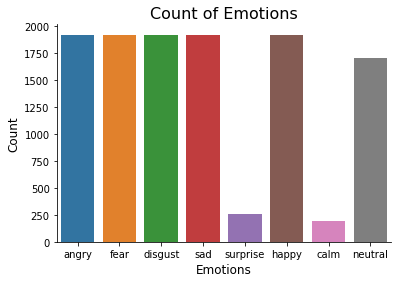

In [35]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_frame.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Ми також можемо побудувати діаграми хвиль і спектрограми для аудіосигналів

* Хвильові діаграми – хвильові діаграми дають нам знати гучність звуку в певний момент часу.
* Спектограми – це візуальне відображення спектру частот звукових або інших сигналів, коли вони змінюються з часом. Це відображення частот, що змінюються щодо часу для заданих звукових/музичних сигналів.


In [36]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

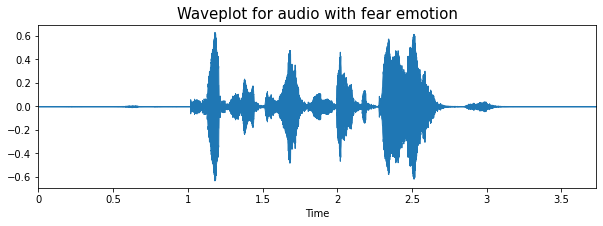

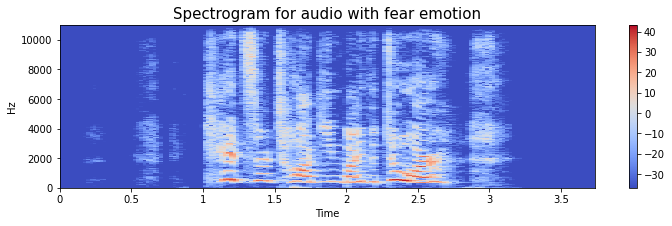

In [37]:
emotion='fear'
path = np.array(data_frame.Path[data_frame.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

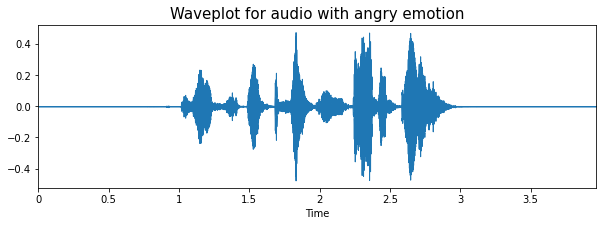

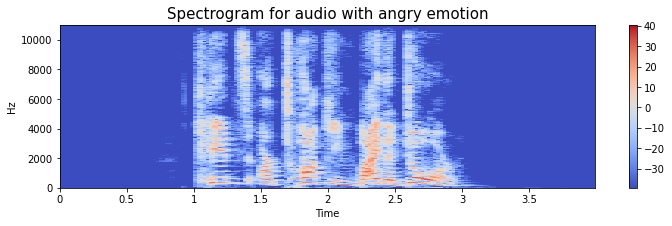

In [38]:
emotion='angry'
path = np.array(data_frame.Path[data_frame.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

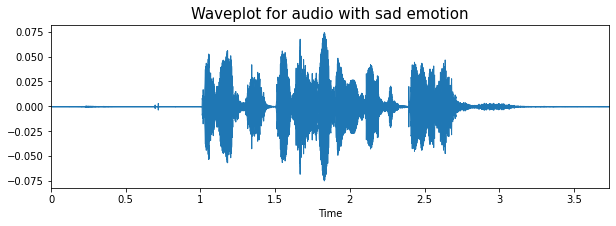

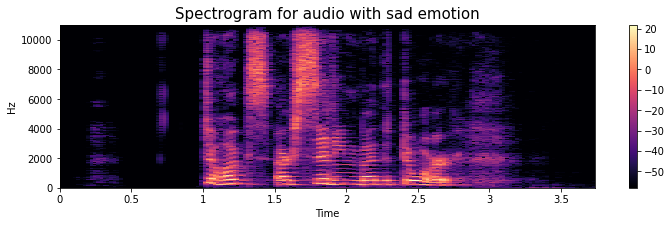

In [39]:
emotion='sad'
path = np.array(data_frame.Path[data_frame.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Розширення даних

- Збільшення даних – це процес, за допомогою якого ми створюємо нові синтетичні вибірки даних, додаючи невеликі збурення до нашого початкового навчального набору.
- Щоб генерувати синтаксичні дані для аудіо, ми можемо застосувати введення шуму, час перемикання, зміну висоти звуку та швидкості.
- Мета полягає в тому, щоб зробити нашу модель інваріантною до цих збурень і підвищити її здатність до узагальнення.
- Щоб це працювало, додавання збурень має зберегти ту саму мітку, що й вихідна навчальна вибірка.
- Збільшення даних у зображеннях може виконуватися шляхом зсуву зображення, масштабування, повороту ...

По-перше, давайте перевіримо, які методи розширення краще працюють для нашого набору даних.

In [40]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_frame.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Просте аудіо

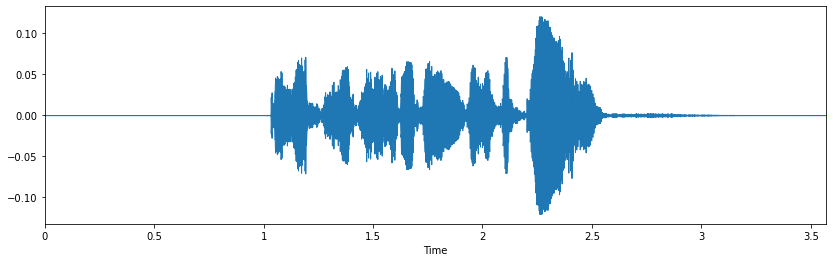

In [41]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Введення шуму

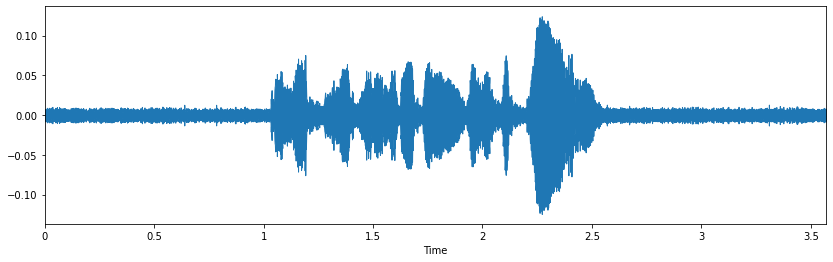

In [42]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

Ми бачимо, що ін’єкція шуму є дуже гарною технікою збільшення, завдяки якій ми можемо запевнити, що наша навчальна модель не перенавчиться

#### 3. Зміна швидкості

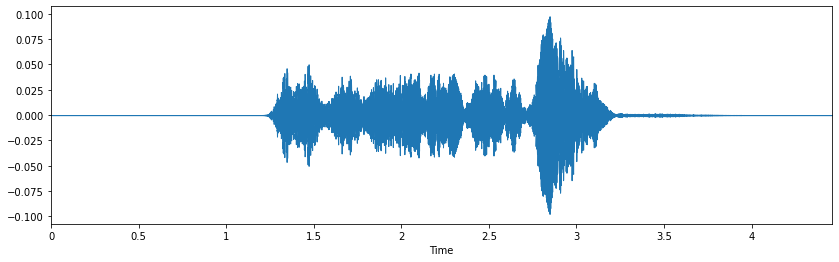

In [43]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Час перемикання

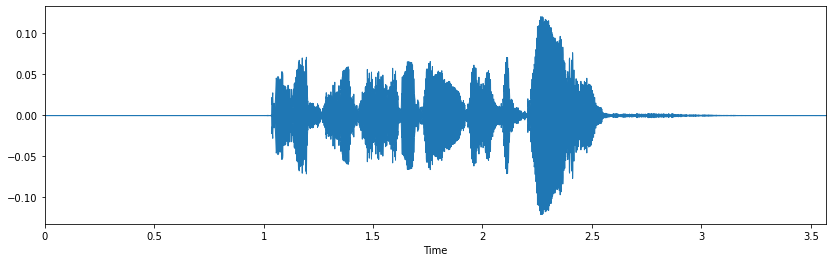

In [44]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


#### 5. Зміна висоти звуку

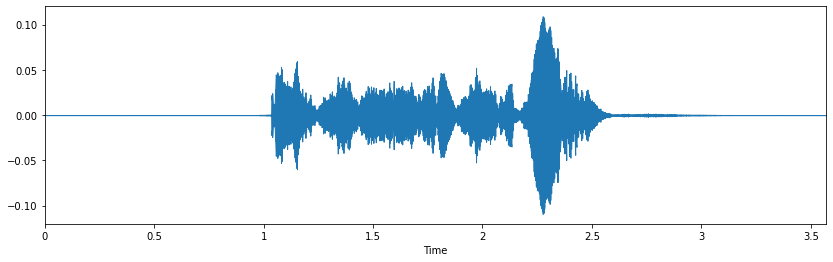

In [45]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- З наведених вище методів розширення даних я використовую шум, зміну швидкості та висоту звуку.